In [1]:
## read demographic data and freesurfer outputs
from pathlib import Path
import nipype.interfaces.io as nio
import pandas as pd
#reading freesurfer results
out_dir = Path("/output")
fig_dir = out_dir / "figs"
fsdata_file = out_dir / 'freesurfer_out_preped.csv'
GROUPS  = ['PD','ET','NC']
tab_data = pd.read_csv(fsdata_file, sep=',', header=0, index_col=0);

#excluding list
tab_data=tab_data.drop(index='sub_0064'); # super large head normal control, NC

# distribution of large brain parts ratio
drop_col_list = ['Left_WM_hypointensities', 'Right_WM_hypointensities', '5th_Ventricle'];
tab_data=tab_data.drop(columns=drop_col_list);
for x in GROUPS:
    print(x , len(tab_data[tab_data["diagnosis"]==x]))

210126-22:07:14,159 nipype.utils WARNING:
	 A newer version (1.5.1) of nipy/nipype is available. You are using 1.5.0
PD 43
ET 38
NC 32


In [2]:
# prepare target data
g_var_list  = ['age', 'sex', 'diagnosis', 'eTIV'];
s_var_list  = ['BrainSegVol','CSF','CerebralWhiteMatterVol','CortexVol', 'Brain_Stem', 'SubCortGrayVol', 'TotalGrayVol',
               'CC_Anterior','CC_Mid_Anterior','CC_Central','CC_Mid_Posterior','CC_Posterior',
               '3rd_Ventricle','4th_Ventricle','SupraTentorialVol'];
lr_var_list = ['Cerebellum_Cortex','Cerebellum_White_Matter',
               'Accumbens_area', 'Amygdala','Hippocampus',
               'Caudate', 'Pallidum', 'Putamen', 'Thalamus_Proper', 
               'Inf_Lat_Vent','Lateral_Ventricle'];
def sum_lr(data, var_list):
    item_left   = [ "Left_"+x  for x in var_list];
    item_right  = [ "Right_"+x for x in var_list];
    for x in var_list:
        data[x] = data['Left_'+x]+ data['Right_'+x];
    return data, var_list+item_left+item_right
curr_data, curr_lr_list = sum_lr(tab_data, lr_var_list);

In [3]:
def ctr_conf(data, ctr_var, y_var, method_name):
    from sklearn import linear_model
    import numpy as np
    dat = data.copy(); n_all = dat.shape[0];
    if method_name == 'dpa': # direct proportion adjustment
        new_col=[];
        for x in y_var:
            r_name = x+'_dpa'; new_col.append(r_name);
            dat[r_name] = dat[x]/dat[ctr_var];
        return dat, new_col
    if method_name == 'pcp': # power_corrected_portion
        reg_list = []; new_col=[];
        log_ctr  = np.log10(np.array(dat[ctr_var]));
        x_mat    = np.hstack((np.ones((n_all, 1)), np.reshape(log_ctr, [n_all, 1])))
        for x in y_var:
            reg = linear_model.LinearRegression()
            y = np.log10(np.array(dat[x]));
            reg.fit(x_mat, y);
            tmp_col = x + "_pcp";
            dat[tmp_col] = dat[x]/np.power(curr_data[ctr_var],reg.coef_[1])
            reg_list.append(reg); new_col.append(tmp_col);
        return dat, new_col, reg_list 
    if method_name == 'rm_norm': #residual based on nc
        nc_data = dat[dat['diagnosis'] == 'NC']; n_nc = nc_data.shape[0];
        x_nc = np.hstack((np.ones((n_nc,1)),  np.array(nc_data[ctr_var]))); 
        x_all= np.hstack((np.ones((n_all,1)), np.array(dat[ctr_var])));
        reg_list = []; new_col=[];
        for x in y_var:
            reg = linear_model.LinearRegression()
            y_nc= np.array(nc_data[x]);
            reg.fit(x_nc, y_nc);
            tmp_col = x+"_rm_norm"
            dat[tmp_col] = dat[x]-np.matmul(x_all[:,1:], reg.coef_[1:])
            dat[tmp_col+"_rm_norm_resid"] = dat[x]-reg.predict(x_all)
            dat[tmp_col+"_rm_norm_resid_per"] = (dat[x]-reg.predict(x_all))/dat[x]
            reg_list.append(reg); new_col.append(tmp_col);
        return dat, new_col, reg_list
    if method_name == 'rm': # classical residual method based on nc
        nc_data = dat[dat['diagnosis'] == 'NC']; n_nc = nc_data.shape[0];
        nc_etiv_mean = np.mean(nc_data[ctr_var]);
        x_nc = np.array(nc_data[ctr_var]).reshape(-1, 1);
        reg_list = []; new_col=[];
        nc_ctr_mean = np.mean(nc_data[ctr_var]);
        for x in y_var:
            reg = linear_model.LinearRegression();
            y_nc= np.array(nc_data[x]);
            reg.fit(x_nc, y_nc);
            tmp_col = x+"_rm"
            dat[tmp_col] = dat[x]-reg.coef_[0]*(dat[ctr_var]-nc_ctr_mean)
            reg_list.append(reg); new_col.append(tmp_col);
        return dat, new_col, reg_list
    if method_name == 'asm': # allometric scaling coefficient (ASC)
        nc_data = dat[dat['diagnosis'] == 'NC']; n_nc = nc_data.shape[0]; 
        x_nc = np.log10(np.hstack((np.ones((n_nc,1)),  np.array(nc_data[ctr_var]).reshape(-1, 1)))); 
        x_all= np.log10(np.hstack((np.ones((n_all,1)), np.array(dat[ctr_var]).reshape(-1, 1))));
        reg_list = []; new_col=[];
        for x in y_var:
            reg = linear_model.LinearRegression()
            y_nc= np.log10(np.array(nc_data[x]));
            reg.fit(x_nc, y_nc);
            tmp_col = x+"_asm"
            dat[tmp_col] = np.log10(dat[x])-np.matmul(x_all[:,1:], reg.coef_[1:])
            reg_list.append(reg); new_col.append(tmp_col);
        return dat, new_col, reg_list 
    if method_name == 'wdcr':# whole dataset confound regression
        pass
    if method_name == 'propensity_score_matching':# whole dataset confound regression
        pass
    if method_name == 'ipsw':# whole dataset confound regression
        pass
    if method_name == 'counter_balancing':# whole dataset confound regression
        pass
    else:
        print([method_name, ' not supported...'])
        return data,[],[]
    return
target_list = ['CSF','CerebralWhiteMatterVol','CortexVol', 'TotalGrayVol',
               'Brain_Stem', 'SubCortGrayVol', 
               'Left_Cerebellum_Cortex','Left_Cerebellum_White_Matter',
               'Right_Cerebellum_Cortex','Right_Cerebellum_White_Matter',
               'Cerebellum_Cortex','Cerebellum_White_Matter'];

In [ ]:
import numpy as np
from sklearn import linear_model
x = 'Cerebellum_White_Matter';
dat = curr_data; ctr_var = 'eTIV'; n_all = dat.shape[0]; 
nc_data = dat[dat['diagnosis'] == 'NC']; n_nc = nc_data.shape[0];
nc_etiv_mean = np.mean(nc_data[ctr_var])
x_nc = np.array(nc_data[ctr_var]).reshape(-1, 1); 
#x_all= np.hstack((np.ones((n_all,1)), np.array(dat[ctr_var])))
#np.array(np.ones(n_nc)).shape
reg = linear_model.LinearRegression()
y_nc= np.array(nc_data[x]);
reg.fit(x_nc, y_nc);
tmp_col = x+"_rm"
dat[tmp_col] = dat[x]-reg.coef_[0]*(dat[x]-nc_etiv_mean)
dat[tmp_col]

In [4]:
# removing confounders
curr_data, rm_norm_list, rm_norm_reg = ctr_conf(
    curr_data, ['age', 'is_Male', 'eTIV'], target_list, 'rm_norm');
curr_data, pcp_list, pcp_reg = ctr_conf(curr_data, 'eTIV', target_list, 'pcp');
curr_data, dpa_list = ctr_conf(curr_data, 'eTIV', target_list, 'dpa');
curr_data, asm_list, asm_reg = ctr_conf(curr_data, 'eTIV', target_list, 'asm');
curr_data, rm_list, rm_reg = ctr_conf(curr_data, 'eTIV', target_list, 'rm');
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm

In [ ]:
# simpler model also works, and log scale works well for volumes.
def comp_models(data, var_):
    import numpy as np
    dat_ = data.copy(); var_log = var_+'_log';
    dat_[var_+'_log'] = np.log10(dat_[var_]); dat_['eTIV_log'] = np.log10(dat_['eTIV']);
    f1 = var_log +'~C(diagnosis, Treatment(reference="NC"))'; m1 = smf.glm(formula=f1, data=dat_); r1 = m1.fit();
    f2 = var_log +'~sex+C(diagnosis, Treatment(reference="NC"))'; m2 = smf.glm(formula=f2, data=dat_); r2 = m2.fit();
    f3 = var_log +'~sex+age+C(diagnosis, Treatment(reference="NC"))'; m3 = smf.glm(formula=f3, data=dat_); r3 = m3.fit();
    f4 = var_log +'~sex+age+eTIV_log+C(diagnosis, Treatment(reference="NC"))'; m4 = smf.glm(formula=f4, data=dat_); r4 = m4.fit();
    f5 = var_log +'~age+sex*eTIV_log+C(diagnosis, Treatment(reference="NC"))'; m5 = smf.glm(formula=f5, data=dat_); r5 = m5.fit();
    f6 = var_ +'~sex+age+eTIV+C(diagnosis, Treatment(reference="NC"))'; m6 = smf.glm(formula=f6, data=dat_); r6 = m6.fit();
    f7 = var_ +'~age+sex*eTIV+C(diagnosis, Treatment(reference="NC"))'; m7 = smf.glm(formula=f7, data=dat_); r7 = m7.fit();
    res_list = [r1, r2, r3, r4, r5, r6, r7];
    return res_list
tar_list = ['Cerebellum_Cortex','Cerebellum_White_Matter','Left_Cerebellum_Cortex','Left_Cerebellum_White_Matter',
            'Right_Cerebellum_Cortex','Right_Cerebellum_White_Matter'];

res_list = comp_models(curr_data, tar_list[0])
for item_ in res_list:
    print(item_.summary2())

In [5]:
def cohen_d(d1, d2):
    # Cohen's d for independent samples with different sample sizes
    import numpy as np
    from math import sqrt
    d1 =np.array(d1); d2 =np.array(d2);
    n1, n2 = len(d1), len(d2) # calculate the size of samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1) # calculate the variance of the samples
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2)) # calculate the pooled standard deviation
    u1, u2 = np.mean(d1), np.mean(d2) # calculate the means of the samples
    d_coh_val = (u1 - u2) / s; # calculate the effect size
    #print('Cohens d: %.3f' % d_coh_val)
    return d_coh_val

def permute_Stats(sample1, sample2, measure, alpha, reps, is_plot):
    import numpy as np
    np.random.seed(115)
    n1, n2 = map(len, (sample1, sample2));
    data = np.concatenate([sample1, sample2])
    ps = np.array([np.random.permutation(n1+n2) for i in range(reps)])
    xp = data[ps[:, :n1]]; yp = data[ps[:, n1:]]
    if measure == 'cohen_d':
        test_stat = cohen_d(sample1, sample2);
        samples = np.array([cohen_d(k, v) for k,v in zip(xp, yp)]);
    p_val = 2*np.sum(samples >= np.abs(test_stat))/reps;
    print(measure+' : %.6f' % test_stat, ", p-value = %.6f " % p_val)
    if is_plot == 1:
        import matplotlib.pyplot as  plt
        fig = plt.figure()
        plt.hist(samples, 25, histtype='step')
        plt.axvline(test_stat, c='r')
        plt.axvline(np.percentile(samples, alpha/2), linestyle='--',c='r')
        plt.axvline(np.percentile(samples, 100-alpha/2), linestyle='--',c='r')
    return [test_stat, p_val, samples]

In [45]:
import numpy as np
np.shape(curr_data.columns)
curr_data.shape

(113, 832)

cohen_d : 0.434886 , p-value = 0.049200 
cohen_d : 0.434886 , p-value = 0.049200 


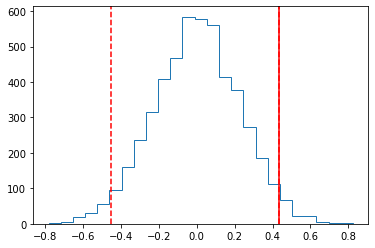

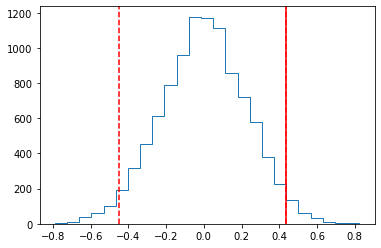

In [152]:
k = 'Cerebellum_Cortex_pcp';
sample_PD = curr_data[curr_data['diagnosis'] == 'PD'][[k]];
sample_ET = curr_data[curr_data['diagnosis'] == 'ET'][[k]];
test_stat = cohen_d(sample_PD, sample_ET);
#print(test_stat)
[test_stat, p_val, samples] = permute_Stats(sample_PD, sample_ET, 'cohen_d', 5, 5000, 1)
[test_stat, p_val, samples] = permute_Stats(sample_PD, sample_ET, 'cohen_d', 5, 10000, 1)

In [6]:
# GLM analysis test the diagnosis vs cerebeller with age and sex controlled 
# 0. controlling volume with covariate
# voi = intercept + beta1*age + beta2*sex + beta3*eTIV + deta4*diagnosis
tar_list = ['Cerebellum_Cortex','Cerebellum_White_Matter','Left_Cerebellum_Cortex','Left_Cerebellum_White_Matter',
            'Right_Cerebellum_Cortex','Right_Cerebellum_White_Matter'];
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm

def glm_covariate(data, tar_list):
    res_dict={}
    for var_ in tar_list:
        res_dict[var_]={};
        formula = var_ +'~age+sex+eTIV+C(diagnosis, Treatment(reference="NC"))'
        mod = smf.glm(formula=formula, data=data)
        res = mod.fit()
        res_dict[var_ ] = {'formula':formula, 'res':res};
    return res_dict
covariate_dict = glm_covariate(curr_data, tar_list);

for k in covariate_dict.keys():
    print('\n')
    print(covariate_dict[k]['formula'],'\n')
    print(covariate_dict[k]['res'].summary2())

from scipy.stats import ranksums
import numpy as np
import pandas as pd
n_permu=10000; alpha=5; res_covariate_df = pd.DataFrame();
stats_cols = ['voi','group','cohen_d','cohen_p','Wilcoxon','Wilcoxon_p'];

for k in covariate_dict.keys():
    print(k)
    sample_PD = curr_data[curr_data['diagnosis'] == 'PD'][[k]];
    sample_ET = curr_data[curr_data['diagnosis'] == 'ET'][[k]];
    sample_NC = curr_data[curr_data['diagnosis'] == 'NC'][[k]];
    [test_stat_etnc, p_val_etnc, samples_etnc] = permute_Stats(sample_ET, sample_NC, 'cohen_d', alpha, n_permu, 0); (rs_etnc, p_etnc)=ranksums(sample_ET, sample_NC);
    [test_stat_pdnc, p_val_pdnc, samples_pdnc] = permute_Stats(sample_PD, sample_NC, 'cohen_d', alpha, n_permu, 0); (rs_pdnc, p_pdnc)=ranksums(sample_PD, sample_NC);
    [test_stat_etpd, p_val_etpd, samples_etpd] = permute_Stats(sample_ET, sample_PD, 'cohen_d', alpha, n_permu, 0); (rs_etpd, p_etpd)=ranksums(sample_ET, sample_PD);
    res_covariate_df=res_covariate_df.append(
        dict(zip(stats_cols, [k,'ETNC',test_stat_etnc, p_val_etnc, rs_etnc, p_etnc])), ignore_index=True);
    res_covariate_df=res_covariate_df.append(
        dict(zip(stats_cols, [k,'PDNC',test_stat_pdnc, p_val_pdnc, rs_pdnc, p_pdnc])), ignore_index=True);
    res_covariate_df=res_covariate_df.append(
        dict(zip(stats_cols, [k,'ETPD',test_stat_etpd, p_val_etpd, rs_etpd, p_etpd])), ignore_index=True);
res_covariate_df



Cerebellum_Cortex~age+sex+eTIV+C(diagnosis, Treatment(reference="NC")) 

                                   Results: Generalized linear model
Model:                          GLM                          AIC:                       2346.1297      
Link Function:                  identity                     BIC:                       6185824401.9102
Dependent Variable:             Cerebellum_Cortex            Log-Likelihood:            -1167.1        
Date:                           2021-01-26 22:07             LL-Null:                   -1208.9        
No. Observations:               113                          Deviance:                  6.1858e+09     
Df Model:                       5                            Pearson chi2:              6.19e+09       
Df Residuals:                   107                          Scale:                     5.7811e+07     
Method:                         IRLS                                                                   
------------------------

,Wilcoxon,Wilcoxon_p,cohen_d,cohen_p,group,voi
0,-0.389053,0.697237,-0.151184,0.5450,ETNC,Cerebellum_Cortex
1,0.074985,0.940227,0.071746,0.7640,PDNC,Cerebellum_Cortex
2,-0.236591,0.812974,-0.208724,0.3520,ETPD,Cerebellum_Cortex
3,-0.742737,0.457641,-0.234761,0.3348,ETNC,Cerebellum_White_Matter
4,-0.599878,0.548588,-0.137800,0.5610,PDNC,Cerebellum_White_Matter
5,-0.397472,0.691019,-0.084501,0.6982,ETPD,Cerebellum_White_Matter
6,-0.176842,0.859632,-0.107637,0.6622,ETNC,Left_Cerebellum_Cortex
7,0.214242,0.830358,0.115690,0.6266,PDNC,Left_Cerebellum_Cortex
8,-0.454254,0.649646,-0.216815,0.3286,ETPD,Left_Cerebellum_Cortex
9,-0.271158,0.786269,-0.079666,0.7340,ETNC,Left_Cerebellum_White_Matter


In [7]:
# GLM analysis test the diagnosis vs cerebeller with age and sex controlled 
# 1. controlling volume with direct proportion adjustment
# volume_dpa = intercept + beta1*age + deta2*diagnosis
tar_list = ['Cerebellum_Cortex','Cerebellum_White_Matter','Left_Cerebellum_Cortex','Left_Cerebellum_White_Matter',
            'Right_Cerebellum_Cortex','Right_Cerebellum_White_Matter'];
dpa_list = [x+"_dpa" for x in tar_list ];
#dpa_et_data = curr_data[curr_data['diagnosis']=='ET' and ]
def glm_dpa(data, dpa_list):
    res_dict={}
    for var_ in dpa_list:
        res_dict[var_]={};
        formula = var_ +'~age+sex+C(diagnosis, Treatment(reference="NC"))'
        mod = smf.glm(formula=formula, data=data)
        res = mod.fit()
        res_dict[var_ ] = {'formula':formula, 'res':res};
    return res_dict
dpa_dict = glm_dpa(curr_data, dpa_list);
for k in dpa_dict.keys():
    print('\n')
    print(dpa_dict[k]['formula'],'\n')
    print(dpa_dict[k]['res'].summary2())

from scipy.stats import ranksums
import numpy as np
import pandas as pd
n_permu=10000; alpha=5; res_dpa_df = pd.DataFrame();
stats_cols = ['voi','group','cohen_d','cohen_p','Wilcoxon','Wilcoxon_p'];

for k in dpa_dict.keys():
    print(k)
    sample_PD = curr_data[curr_data['diagnosis'] == 'PD'][[k]];
    sample_ET = curr_data[curr_data['diagnosis'] == 'ET'][[k]];
    sample_NC = curr_data[curr_data['diagnosis'] == 'NC'][[k]];
    [test_stat_etnc, p_val_etnc, samples_etnc] = permute_Stats(sample_ET, sample_NC, 'cohen_d', alpha, n_permu, 0); (rs_etnc, p_etnc)=ranksums(sample_ET, sample_NC);
    [test_stat_pdnc, p_val_pdnc, samples_pdnc] = permute_Stats(sample_PD, sample_NC, 'cohen_d', alpha, n_permu, 0); (rs_pdnc, p_pdnc)=ranksums(sample_PD, sample_NC);
    [test_stat_etpd, p_val_etpd, samples_etpd] = permute_Stats(sample_ET, sample_PD, 'cohen_d', alpha, n_permu, 0); (rs_etpd, p_etpd)=ranksums(sample_ET, sample_PD);
    res_dpa_df=res_dpa_df.append(
        dict(zip(stats_cols, [k,'ETNC',test_stat_etnc, p_val_etnc, rs_etnc, p_etnc])), ignore_index=True);
    res_dpa_df=res_dpa_df.append(
        dict(zip(stats_cols, [k,'PDNC',test_stat_pdnc, p_val_pdnc, rs_pdnc, p_pdnc])), ignore_index=True);
    res_dpa_df=res_dpa_df.append(
        dict(zip(stats_cols, [k,'ETPD',test_stat_etpd, p_val_etpd, rs_etpd, p_etpd])), ignore_index=True);
res_dpa_df



Cerebellum_Cortex_dpa~age+sex+C(diagnosis, Treatment(reference="NC")) 

                              Results: Generalized linear model
Model:                       GLM                           AIC:                    -838.6407 
Link Function:               identity                      BIC:                    -510.5543 
Dependent Variable:          Cerebellum_Cortex_dpa         Log-Likelihood:         424.32    
Date:                        2021-01-26 22:13              LL-Null:                404.46    
No. Observations:            113                           Deviance:               0.0036225 
Df Model:                    4                             Pearson chi2:           0.00362   
Df Residuals:                108                           Scale:                  3.3542e-05
Method:                      IRLS                                                            
---------------------------------------------------------------------------------------------
                

,Wilcoxon,Wilcoxon_p,cohen_d,cohen_p,group,voi
0,-2.074949,0.037991,-0.436168,0.0770,ETNC,Cerebellum_Cortex_dpa
1,0.664150,0.506594,0.212970,0.3690,PDNC,Cerebellum_Cortex_dpa
2,-2.365907,0.017986,-0.551931,0.0172,ETPD,Cerebellum_Cortex_dpa
3,-2.051370,0.040231,-0.431377,0.0774,ETNC,Cerebellum_White_Matter_dpa
4,-0.332075,0.739833,-0.036528,0.8702,PDNC,Cerebellum_White_Matter_dpa
5,-1.608817,0.107656,-0.377169,0.0922,ETPD,Cerebellum_White_Matter_dpa
6,-1.874527,0.060858,-0.390585,0.1152,ETNC,Left_Cerebellum_Cortex_dpa
7,1.092634,0.274554,0.263956,0.2626,PDNC,Left_Cerebellum_Cortex_dpa
8,-2.422689,0.015406,-0.555418,0.0162,ETPD,Left_Cerebellum_Cortex_dpa
9,-1.414738,0.157145,-0.289787,0.2322,ETNC,Left_Cerebellum_White_Matter_dpa


In [8]:
# GLM analysis test the diagnosis vs cerebeller with age and sex controlled 
# 2. controlling volume with pcp al
# volume_pcp = intercept + beta1*age + beta2*sex + beta3*diagnosis
tar_list = ['Cerebellum_Cortex','Cerebellum_White_Matter','Left_Cerebellum_Cortex','Left_Cerebellum_White_Matter',
            'Right_Cerebellum_Cortex','Right_Cerebellum_White_Matter'];
pcp_list = [x+"_pcp" for x in tar_list ];
#dpa_et_data = curr_data[curr_data['diagnosis']=='ET' and ]
def glm_pcp(data, pcp_list):
    res_dict={}
    for var_ in dpa_list:
        res_dict[var_]={};
        formula = var_ +'~age+sex+C(diagnosis, Treatment(reference="NC"))'
        mod = smf.glm(formula=formula, data=data)
        res = mod.fit()
        res_dict[var_ ] = {'formula':formula, 'res':res};
    return res_dict
pcp_dict = glm_pcp(curr_data, pcp_list);
for k in pcp_dict.keys():
    print('\n')
    print(pcp_dict[k]['formula'],'\n')
    print(pcp_dict[k]['res'].summary2())

from scipy.stats import ranksums
import numpy as np
import pandas as pd
n_permu=10000; alpha=5; res_pcp_df = pd.DataFrame();
stats_cols = ['voi','group','cohen_d','cohen_p','Wilcoxon','Wilcoxon_p'];

for k in pcp_dict.keys():
    print(k)
    sample_PD = curr_data[curr_data['diagnosis'] == 'PD'][[k]];
    sample_ET = curr_data[curr_data['diagnosis'] == 'ET'][[k]];
    sample_NC = curr_data[curr_data['diagnosis'] == 'NC'][[k]];
    [test_stat_etnc, p_val_etnc, samples_etnc] = permute_Stats(sample_ET, sample_NC, 'cohen_d', alpha, n_permu, 0); (rs_etnc, p_etnc)=ranksums(sample_ET, sample_NC);
    [test_stat_pdnc, p_val_pdnc, samples_pdnc] = permute_Stats(sample_PD, sample_NC, 'cohen_d', alpha, n_permu, 0); (rs_pdnc, p_pdnc)=ranksums(sample_PD, sample_NC);
    [test_stat_etpd, p_val_etpd, samples_etpd] = permute_Stats(sample_ET, sample_PD, 'cohen_d', alpha, n_permu, 0); (rs_etpd, p_etpd)=ranksums(sample_ET, sample_PD);
    res_pcp_df=res_pcp_df.append(
        dict(zip(stats_cols, [k,'ETNC',test_stat_etnc, p_val_etnc, rs_etnc, p_etnc])), ignore_index=True);
    res_pcp_df=res_pcp_df.append(
        dict(zip(stats_cols, [k,'PDNC',test_stat_pdnc, p_val_pdnc, rs_pdnc, p_pdnc])), ignore_index=True);
    res_pcp_df=res_pcp_df.append(
        dict(zip(stats_cols, [k,'ETPD',test_stat_etpd, p_val_etpd, rs_etpd, p_etpd])), ignore_index=True);
res_pcp_df



Cerebellum_Cortex_dpa~age+sex+C(diagnosis, Treatment(reference="NC")) 

                              Results: Generalized linear model
Model:                       GLM                           AIC:                    -838.6407 
Link Function:               identity                      BIC:                    -510.5543 
Dependent Variable:          Cerebellum_Cortex_dpa         Log-Likelihood:         424.32    
Date:                        2021-01-26 22:53              LL-Null:                404.46    
No. Observations:            113                           Deviance:               0.0036225 
Df Model:                    4                             Pearson chi2:           0.00362   
Df Residuals:                108                           Scale:                  3.3542e-05
Method:                      IRLS                                                            
---------------------------------------------------------------------------------------------
                

,Wilcoxon,Wilcoxon_p,cohen_d,cohen_p,group,voi
0,-2.074949,0.037991,-0.436168,0.0770,ETNC,Cerebellum_Cortex_dpa
1,0.664150,0.506594,0.212970,0.3690,PDNC,Cerebellum_Cortex_dpa
2,-2.365907,0.017986,-0.551931,0.0172,ETPD,Cerebellum_Cortex_dpa
3,-2.051370,0.040231,-0.431377,0.0774,ETNC,Cerebellum_White_Matter_dpa
4,-0.332075,0.739833,-0.036528,0.8702,PDNC,Cerebellum_White_Matter_dpa
5,-1.608817,0.107656,-0.377169,0.0922,ETPD,Cerebellum_White_Matter_dpa
6,-1.874527,0.060858,-0.390585,0.1152,ETNC,Left_Cerebellum_Cortex_dpa
7,1.092634,0.274554,0.263956,0.2626,PDNC,Left_Cerebellum_Cortex_dpa
8,-2.422689,0.015406,-0.555418,0.0162,ETPD,Left_Cerebellum_Cortex_dpa
9,-1.414738,0.157145,-0.289787,0.2322,ETNC,Left_Cerebellum_White_Matter_dpa


In [9]:
# GLM analysis test the diagnosis vs cerebeller with age and sex controlled 
# 3. controlling volume with residual method against NC, 
# volume_dpa = intercept + deta1*diagnosis
tar_list = ['Cerebellum_Cortex','Cerebellum_White_Matter','Left_Cerebellum_Cortex','Left_Cerebellum_White_Matter',
            'Right_Cerebellum_Cortex','Right_Cerebellum_White_Matter'];
rm_norm_list = [x+"_rm_norm" for x in tar_list ];
#dpa_et_data = curr_data[curr_data['diagnosis']=='ET' and ]
def glm_rm_norm(data, rm_norm_list):
    res_dict={}
    for var_ in rm_norm_list:
        res_dict[var_]={};
        formula = var_ +'~C(diagnosis, Treatment(reference="NC"))'
        mod = smf.glm(formula=formula, data=data)
        res = mod.fit()
        res_dict[var_ ] = {'formula':formula, 'res':res};
    return res_dict
rm_norm_dict = glm_rm_norm(curr_data, rm_norm_list);
for k in rm_norm_dict.keys():
    print('\n')
    print(rm_norm_dict[k]['formula'],'\n')
    print(rm_norm_dict[k]['res'].summary2())

from scipy.stats import ranksums
import numpy as np
import pandas as pd
n_permu=10000; alpha=5; res_rm_norm_df = pd.DataFrame();
stats_cols = ['voi','group','cohen_d','cohen_p','Wilcoxon','Wilcoxon_p'];

for k in rm_norm_dict.keys():
    print(k)
    sample_PD = curr_data[curr_data['diagnosis'] == 'PD'][[k]];
    sample_ET = curr_data[curr_data['diagnosis'] == 'ET'][[k]];
    sample_NC = curr_data[curr_data['diagnosis'] == 'NC'][[k]];
    [test_stat_etnc, p_val_etnc, samples_etnc] = permute_Stats(sample_ET, sample_NC, 'cohen_d', alpha, n_permu, 0); (rs_etnc, p_etnc)=ranksums(sample_ET, sample_NC);
    [test_stat_pdnc, p_val_pdnc, samples_pdnc] = permute_Stats(sample_PD, sample_NC, 'cohen_d', alpha, n_permu, 0); (rs_pdnc, p_pdnc)=ranksums(sample_PD, sample_NC);
    [test_stat_etpd, p_val_etpd, samples_etpd] = permute_Stats(sample_ET, sample_PD, 'cohen_d', alpha, n_permu, 0); (rs_etpd, p_etpd)=ranksums(sample_ET, sample_PD);
    res_rm_norm_df=res_rm_norm_df.append(
        dict(zip(stats_cols, [k,'ETNC',test_stat_etnc, p_val_etnc, rs_etnc, p_etnc])), ignore_index=True);
    res_rm_norm_df=res_rm_norm_df.append(
        dict(zip(stats_cols, [k,'PDNC',test_stat_pdnc, p_val_pdnc, rs_pdnc, p_pdnc])), ignore_index=True);
    res_rm_norm_df=res_rm_norm_df.append(
        dict(zip(stats_cols, [k,'ETPD',test_stat_etpd, p_val_etpd, rs_etpd, p_etpd])), ignore_index=True);
res_rm_norm_df



Cerebellum_Cortex_rm_norm~C(diagnosis, Treatment(reference="NC")) 

                                   Results: Generalized linear model
Model:                        GLM                               AIC:                    2351.2414      
Link Function:                identity                          BIC:                    6825005503.2120
Dependent Variable:           Cerebellum_Cortex_rm_norm         Log-Likelihood:         -1172.6        
Date:                         2021-01-26 22:55                  LL-Null:                -1174.1        
No. Observations:             113                               Deviance:               6.8250e+09     
Df Model:                     2                                 Pearson chi2:           6.83e+09       
Df Residuals:                 110                               Scale:                  6.2046e+07     
Method:                       IRLS                                                                     
-----------------------------

,Wilcoxon,Wilcoxon_p,cohen_d,cohen_p,group,voi
0,0.872422,0.382978,0.190577,0.4302,ETNC,Cerebellum_Cortex_rm_norm
1,1.735360,0.082677,0.362861,0.1238,PDNC,Cerebellum_Cortex_rm_norm
2,-1.012608,0.311247,-0.213215,0.3328,ETPD,Cerebellum_Cortex_rm_norm
3,-1.544422,0.122486,-0.342714,0.1602,ETNC,Cerebellum_White_Matter_rm_norm
4,-0.696286,0.486249,-0.113672,0.6258,PDNC,Cerebellum_White_Matter_rm_norm
5,-0.965290,0.334400,-0.218423,0.3182,ETPD,Cerebellum_White_Matter_rm_norm
6,1.025685,0.305040,0.253320,0.3008,ETNC,Left_Cerebellum_Cortex_rm_norm
7,1.992451,0.046322,0.430160,0.0666,PDNC,Left_Cerebellum_Cortex_rm_norm
8,-1.078854,0.280653,-0.214627,0.3370,ETPD,Left_Cerebellum_Cortex_rm_norm
9,-0.978527,0.327814,-0.234569,0.3336,ETNC,Left_Cerebellum_White_Matter_rm_norm


In [10]:
# GLM analysis test the diagnosis vs cerebeller with age and sex controlled 
# 4. controlling volume with residual method against NC (mean), 
# volume_dpa = intercept + beta1*age + beta2*sex + deta1*diagnosis
tar_list = ['Cerebellum_Cortex','Cerebellum_White_Matter','Left_Cerebellum_Cortex','Left_Cerebellum_White_Matter',
            'Right_Cerebellum_Cortex','Right_Cerebellum_White_Matter'];
rm_list = [x+"_rm" for x in tar_list ];
#dpa_et_data = curr_data[curr_data['diagnosis']=='ET' and ]
def glm_rm(data, rm_list):
    res_dict={}
    for var_ in rm_list:
        res_dict[var_]={};
        formula = var_ +'~age+sex+C(diagnosis, Treatment(reference="NC"))'
        mod = smf.glm(formula=formula, data=data)
        res = mod.fit()
        res_dict[var_ ] = {'formula':formula, 'res':res};
    return res_dict
rm_dict = glm_rm(curr_data, rm_list);
for k in rm_dict.keys():
    print('\n')
    print(rm_dict[k]['formula'],'\n')
    print(rm_dict[k]['res'].summary2())

from scipy.stats import ranksums
import numpy as np
import pandas as pd
n_permu=10000; alpha=5; res_rm_df = pd.DataFrame();
stats_cols = ['voi','group','cohen_d','cohen_p','Wilcoxon','Wilcoxon_p'];

for k in rm_dict.keys():
    print(k)
    sample_PD = curr_data[curr_data['diagnosis'] == 'PD'][[k]];
    sample_ET = curr_data[curr_data['diagnosis'] == 'ET'][[k]];
    sample_NC = curr_data[curr_data['diagnosis'] == 'NC'][[k]];
    [test_stat_etnc, p_val_etnc, samples_etnc] = permute_Stats(sample_ET, sample_NC, 'cohen_d', alpha, n_permu, 0); (rs_etnc, p_etnc)=ranksums(sample_ET, sample_NC);
    [test_stat_pdnc, p_val_pdnc, samples_pdnc] = permute_Stats(sample_PD, sample_NC, 'cohen_d', alpha, n_permu, 0); (rs_pdnc, p_pdnc)=ranksums(sample_PD, sample_NC);
    [test_stat_etpd, p_val_etpd, samples_etpd] = permute_Stats(sample_ET, sample_PD, 'cohen_d', alpha, n_permu, 0); (rs_etpd, p_etpd)=ranksums(sample_ET, sample_PD);
    res_rm_df=res_rm_df.append(
        dict(zip(stats_cols, [k,'ETNC',test_stat_etnc, p_val_etnc, rs_etnc, p_etnc])), ignore_index=True);
    res_rm_df=res_rm_df.append(
        dict(zip(stats_cols, [k,'PDNC',test_stat_pdnc, p_val_pdnc, rs_pdnc, p_pdnc])), ignore_index=True);
    res_rm_df=res_rm_df.append(
        dict(zip(stats_cols, [k,'ETPD',test_stat_etpd, p_val_etpd, rs_etpd, p_etpd])), ignore_index=True);
res_rm_df



Cerebellum_Cortex_rm~age+sex+C(diagnosis, Treatment(reference="NC")) 

                                    Results: Generalized linear model
Model:                          GLM                             AIC:                       2354.6692      
Link Function:                  identity                        BIC:                       6790534027.2738
Dependent Variable:             Cerebellum_Cortex_rm            Log-Likelihood:            -1172.3        
Date:                           2021-01-26 22:57                LL-Null:                   -1191.8        
No. Observations:               113                             Deviance:                  6.7905e+09     
Df Model:                       4                               Pearson chi2:              6.79e+09       
Df Residuals:                   108                             Scale:                     6.2875e+07     
Method:                         IRLS                                                                      
-

,Wilcoxon,Wilcoxon_p,cohen_d,cohen_p,group,voi
0,-1.909896,0.056147,-0.454876,0.0638,ETNC,Cerebellum_Cortex_rm
1,0.321363,0.747935,0.157236,0.4996,PDNC,Cerebellum_Cortex_rm
2,-2.280734,0.022564,-0.519497,0.0206,ETPD,Cerebellum_Cortex_rm
3,-1.509053,0.131285,-0.343943,0.1620,ETNC,Cerebellum_White_Matter_rm
4,-0.696286,0.486249,-0.114855,0.6270,PDNC,Cerebellum_White_Matter_rm
5,-0.965290,0.334400,-0.219044,0.3132,ETPD,Cerebellum_White_Matter_rm
6,-1.780212,0.075041,-0.410098,0.0972,ETNC,Left_Cerebellum_Cortex_rm
7,0.814120,0.415576,0.211822,0.3658,PDNC,Left_Cerebellum_Cortex_rm
8,-2.365907,0.017986,-0.529626,0.0188,ETPD,Left_Cerebellum_Cortex_rm
9,-0.730948,0.464811,-0.173684,0.4660,ETNC,Left_Cerebellum_White_Matter_rm


In [11]:
# GLM analysis test the diagnosis vs cerebeller with age and sex controlled 
# 5. controlling volume with asm
# volume_dpa = intercept + beta1*age + deta2*diagnosis
tar_list = ['Cerebellum_Cortex','Cerebellum_White_Matter','Left_Cerebellum_Cortex','Left_Cerebellum_White_Matter',
            'Right_Cerebellum_Cortex','Right_Cerebellum_White_Matter'];
asm_list = [x+"_asm" for x in tar_list ];
#dpa_et_data = curr_data[curr_data['diagnosis']=='ET' and ]
def glm_asm(data, asm_list):
    res_dict={}
    for var_ in asm_list:
        res_dict[var_]={};
        formula = var_ +'~age+sex+C(diagnosis, Treatment(reference="NC"))'
        mod = smf.glm(formula=formula, data=data)
        res = mod.fit()
        res_dict[var_ ] = {'formula':formula, 'res':res};
    return res_dict
asm_dict = glm_asm(curr_data, asm_list);
for k in asm_dict.keys():
    print('\n')
    print(asm_dict[k]['formula'],'\n')
    print(asm_dict[k]['res'].summary2())

from scipy.stats import ranksums
import numpy as np
import pandas as pd
n_permu=10000; alpha=5; res_asm_df = pd.DataFrame();
stats_cols = ['voi','group','cohen_d','cohen_p','Wilcoxon','Wilcoxon_p'];

for k in asm_dict.keys():
    print(k)
    sample_PD = curr_data[curr_data['diagnosis'] == 'PD'][[k]];
    sample_ET = curr_data[curr_data['diagnosis'] == 'ET'][[k]];
    sample_NC = curr_data[curr_data['diagnosis'] == 'NC'][[k]];
    [test_stat_etnc, p_val_etnc, samples_etnc] = permute_Stats(sample_ET, sample_NC, 'cohen_d', alpha, n_permu, 0); (rs_etnc, p_etnc)=ranksums(sample_ET, sample_NC);
    [test_stat_pdnc, p_val_pdnc, samples_pdnc] = permute_Stats(sample_PD, sample_NC, 'cohen_d', alpha, n_permu, 0); (rs_pdnc, p_pdnc)=ranksums(sample_PD, sample_NC);
    [test_stat_etpd, p_val_etpd, samples_etpd] = permute_Stats(sample_ET, sample_PD, 'cohen_d', alpha, n_permu, 0); (rs_etpd, p_etpd)=ranksums(sample_ET, sample_PD);
    res_asm_df=res_asm_df.append(
        dict(zip(stats_cols, [k,'ETNC',test_stat_etnc, p_val_etnc, rs_etnc, p_etnc])), ignore_index=True);
    res_asm_df=res_asm_df.append(
        dict(zip(stats_cols, [k,'PDNC',test_stat_pdnc, p_val_pdnc, rs_pdnc, p_pdnc])), ignore_index=True);
    res_asm_df=res_asm_df.append(
        dict(zip(stats_cols, [k,'ETPD',test_stat_etpd, p_val_etpd, rs_etpd, p_etpd])), ignore_index=True);
res_rm_df



Cerebellum_Cortex_asm~age+sex+C(diagnosis, Treatment(reference="NC")) 

                              Results: Generalized linear model
Model:                        GLM                           AIC:                    -445.4647
Link Function:                identity                      BIC:                    -510.4404
Dependent Variable:           Cerebellum_Cortex_asm         Log-Likelihood:         227.73   
Date:                         2021-01-26 23:03              LL-Null:                209.14   
No. Observations:             113                           Deviance:               0.11752  
Df Model:                     4                             Pearson chi2:           0.118    
Df Residuals:                 108                           Scale:                  0.0010881
Method:                       IRLS                                                           
---------------------------------------------------------------------------------------------
                

,Wilcoxon,Wilcoxon_p,cohen_d,cohen_p,group,voi
0,-1.909896,0.056147,-0.454876,0.0638,ETNC,Cerebellum_Cortex_rm
1,0.321363,0.747935,0.157236,0.4996,PDNC,Cerebellum_Cortex_rm
2,-2.280734,0.022564,-0.519497,0.0206,ETPD,Cerebellum_Cortex_rm
3,-1.509053,0.131285,-0.343943,0.1620,ETNC,Cerebellum_White_Matter_rm
4,-0.696286,0.486249,-0.114855,0.6270,PDNC,Cerebellum_White_Matter_rm
5,-0.965290,0.334400,-0.219044,0.3132,ETPD,Cerebellum_White_Matter_rm
6,-1.780212,0.075041,-0.410098,0.0972,ETNC,Left_Cerebellum_Cortex_rm
7,0.814120,0.415576,0.211822,0.3658,PDNC,Left_Cerebellum_Cortex_rm
8,-2.365907,0.017986,-0.529626,0.0188,ETPD,Left_Cerebellum_Cortex_rm
9,-0.730948,0.464811,-0.173684,0.4660,ETNC,Left_Cerebellum_White_Matter_rm


In [17]:
import seaborn as sns
sns.set_theme(style="darkgrid")
g = sns.jointplot(x='Cerebellum_Cortex_pcp', y='Cerebellum_White_Matter_pcp', 
                  data=curr_data[curr_data['diagnosis']=='PD'], xlim=(80, 150), ylim=(80, 130),
                  kind="reg", truncate=False, color="b", height=7)
g = sns.jointplot(x='Cerebellum_Cortex_pcp', y='Cerebellum_White_Matter_pcp', 
                  data=curr_data[curr_data['diagnosis']=='ET'], xlim=(80, 150), ylim=(80, 130),
                  kind="reg", truncate=False, color="orange", height=7)
g = sns.jointplot(x='Cerebellum_Cortex_pcp', y='Cerebellum_White_Matter_pcp', 
                  data=curr_data[curr_data['diagnosis']=='NC'], xlim=(80, 150), ylim=(80, 130),
                  kind="reg", truncate=False, color="g", height=7)

NameError: name 'sns' is not defined

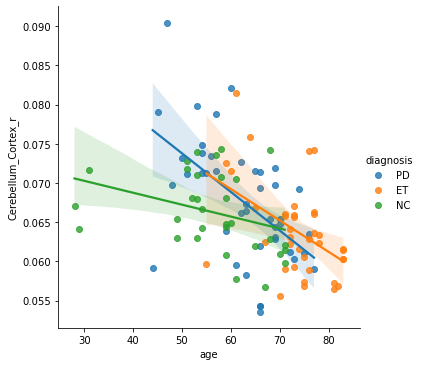

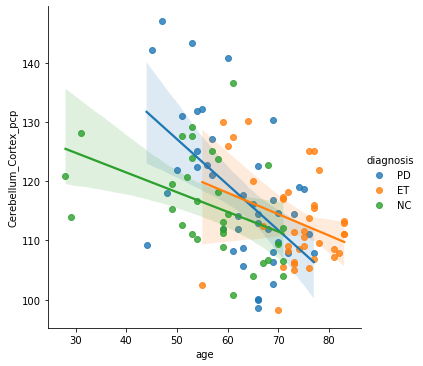

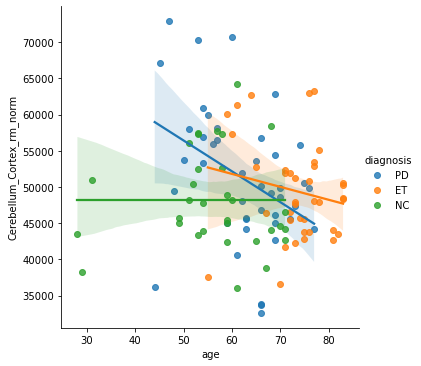

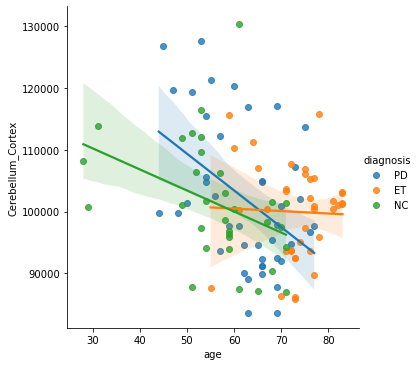

In [15]:
import seaborn as sns
sns.lmplot(data=curr_data, x="age", y='Cerebellum_Cortex_r', hue="diagnosis")
sns.lmplot(data=curr_data, x="age", y='Cerebellum_Cortex_pcp', hue="diagnosis")
sns.lmplot(data=curr_data, x="age", y='Cerebellum_Cortex_rm_norm', hue="diagnosis")
sns.lmplot(data=curr_data, x="age", y='Cerebellum_Cortex', hue="diagnosis")

/usr/local/miniconda/lib/python3.7/site-packages/seaborn/axisgrid.py:1629: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


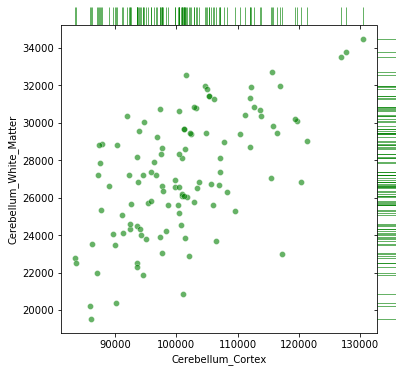

In [16]:
#distribution
g = sns.JointGrid(data=tab_data, x="Cerebellum_Cortex", y="Cerebellum_White_Matter", space=0, ratio=17)
g.plot_joint(sns.scatterplot,
             color="g", alpha=.6, legend=False)
g.plot_marginals(sns.rugplot, height=1, color="g",alpha=.6)
                 